# Configuration

In [14]:
fractionOfData = 1

# Import

In [1]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

# Specific tf libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Helper functions

In [2]:
%run utils.py

# Load data

## Metadata

In [3]:
metaData_apartment = pd.read_json('../data/apartments_meta.json')
metaData_building = pd.read_json('../data/buildings_meta.json')

In [4]:
metaData_apartment.at[0, 'name'] = 'apartment_id'
metaData_building.at[0, 'name'] = 'building_id'

In [5]:
metaData = pd.concat([metaData_apartment, metaData_building])

In [6]:
metaDataDict = {}
for index, row in metaData.iterrows():
    metaDataDict[row['name']] = {'type':list(row)[1], 'categories':list(row)[3]}

In [7]:
metaDataDict['seller']

{'type': 'categorical',
 'categories': ['Owner', 'Company', 'Agents', 'Developer']}

In [8]:
metaDataDict['apartment_id']['categories']

nan

In [9]:
metaData

,name,type,desc,cats
0,apartment_id,integer_id,Unique ID for apartment,NaN
1,seller,categorical,The type of apartment seller,"[Owner, Company, Agents, Developer]"
2,price,real,The listed price of the apartment (TARGET),NaN
3,area_total,real,Total area of the apartment,NaN
4,area_kitchen,real,Total kitchen area in the apartment,NaN
5,area_living,real,Total living space area in the apartment,NaN
6,floor,integer,Primary building floor of the apartment,NaN
7,rooms,integer,Number of rooms in the apartment,NaN
8,layout,categorical,Overal apartment layout,"[Adjacent, Isolated, Adjacent_isolated]"
9,ceiling,real,Ceiling height in the apartment,NaN


## Train data

In [10]:
train_apartment = pd.read_csv('../data/apartments_train.csv')

In [11]:
train_building = pd.read_csv('../data/buildings_train.csv')

In [12]:
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
#train.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [15]:
# Reduce amount of data for performance reasons during implementation.
train = train.head(int(train.shape[0] * fractionOfData))
train.head()

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,12,3.0,4045140.0,19.8,5.2,9.6,17.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
2,55,3.0,9500240.0,79.7,17.0,41.5,9.0,3.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,104,3.0,4326660.0,23.4,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
4,106,3.0,4333980.0,23.8,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN


## Test data

In [16]:
test_apartment = pd.read_csv('../data/apartments_test.csv')

In [17]:
test_building = pd.read_csv('../data/buildings_test.csv')

In [18]:
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)
test.tail()

,apartment_id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
9932,33150,NaN,29.0,NaN,NaN,5.0,1.0,NaN,2.64,0.0,...,6,2014.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
9933,33153,NaN,87.0,12.0,NaN,6.0,3.0,NaN,2.50,0.0,...,105к2,NaN,NaN,17.0,0.0,1.0,1.0,NaN,NaN,NaN
9934,33163,NaN,58.1,12.0,30.0,14.0,2.0,1.0,2.70,0.0,...,12,2016.0,NaN,17.0,0.0,1.0,1.0,NaN,NaN,NaN
9935,33208,1.0,54.7,5.5,36.9,2.0,3.0,NaN,2.64,1.0,...,10К2,1963.0,4.0,5.0,1.0,0.0,0.0,NaN,NaN,0.0
9936,33221,1.0,71.5,7.0,49.0,2.0,3.0,NaN,NaN,NaN,...,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


# Initial simple test
## Data processing
We want to do a simple test where we only use area_total, ceiling and rooms.
We need to do something about the nan-values. First lets check if there are any, and how severe the situation is.

In [18]:
simple_train = train[['apartment_id','area_total','ceiling','rooms', 'price']]
simple_test = test[['apartment_id','area_total','ceiling','rooms']]

In [199]:
# If we found nan-values in price, we couldn't use it as training data.
print("Is all training data labeled? ", end="")
print(len(simple_train['price'].dropna()) == len(simple_train['price']))

Is all training data labeled? True


In [200]:
# Alright, then we need to fix ceilings. Lets just drop all values with nan, or replace them with mean.
simple_train=simple_train.fillna(simple_train.mean())
simple_test=simple_test.fillna(simple_test.mean())
print(len(simple_train['ceiling'].dropna()), len(simple_train['ceiling']))
print(simple_train['ceiling'].mean())

23285 23285
3.2683735236220466


## Training
Using a sequential deep ANN model to extraxt and train on features.

In [28]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [24]:
# Split data into labels and features. Normalize feature data.
simple_train_labels = simple_train['price']
simple_train_features = simple_train[['area_total','ceiling','rooms']]

In [85]:
# Model
model = tf.keras.Sequential()
model.add(Dense(8, activation=tf.nn.relu)) #, input_shape=[3]
model.add(Dropout(0.5))
model.add(Dense(3, activation=tf.nn.relu))
model.add(Dropout(0.5))
model.add(Dense(1))#Output

model.compile(optimizer='adam', 
              loss='msle', #tf.keras.losses.MeanSquaredLogarithmicError
              metrics=['mae', 'mse', 'msle']) #-msle


In [86]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=50)

history = model.fit(x=simple_train_features, y=simple_train_labels,
                    epochs=500, verbose=0, validation_split = 0.1, batch_size=128,
                    callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [162]:
# Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,msle,val_loss,val_mae,val_mse,val_msle,epoch
495,39.768353,17750564.0,2.398123e+15,39.768353,0.136761,5633465.0,5.645145e+14,0.136761,495
496,39.916191,17754844.0,2.586916e+15,39.916191,0.136821,5634120.5,5.645672e+14,0.136821,496
497,39.752602,17739636.0,2.254727e+15,39.752602,0.136574,5630433.5,5.640003e+14,0.136574,497
498,39.482071,17837748.0,2.385224e+15,39.482071,0.136756,5632710.0,5.642854e+14,0.136756,498
499,39.518311,17939492.0,2.546715e+15,39.518311,0.136820,5633378.5,5.643425e+14,0.136820,499


In [ ]:
plot_history(hist)

## Predicting / inference
Lets see how well our model does in the competition!

In [153]:
result = model.predict(simple_test[['area_total','ceiling','rooms']])

In [154]:
submission_1 = pd.DataFrame()
submission_1['id'] = simple_test['apartment_id']
submission_1['price_prediction'] = result
print("No. predictions:",len(submission_1['id']))

No. predictions: 9937


In [156]:
submission_1_sorted = submission_1.sort_values(['id', 'price_prediction'], ascending=True)

In [163]:
submission_1_sorted.to_csv('simple_test_1', index=False)

## Second test.
### Data processing
Removing outliers from training data this time.

In [29]:
from scipy import stats
outliers_value = 4

In [202]:
print("Before removing:",len(simple_train))
simple_train = simple_train[(np.abs(stats.zscore(simple_train['price'])) < outliers_value)]
print("After:",len(simple_train))

Before removing: 23285
After: 23113


### Training

In [184]:
# Model 2
model2 = tf.keras.Sequential()
model2.add(Dense(8, activation=tf.nn.relu)) #, input_shape=[3]
model2.add(Dropout(0.5))
model2.add(Dense(3, activation=tf.nn.relu))
model2.add(Dropout(0.5))
model2.add(Dense(1))#Output
model2.compile(optimizer='adam', 
              loss='msle', 
              metrics=['msle']) #-msle


In [185]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=40)

history2 = model2.fit(x=simple_train[['area_total','ceiling','rooms']], y=simple_train['price'],
                    epochs=500, verbose=0, validation_split = 0.1, batch_size=128,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................................................Epoch 00495: early stopping


In [186]:
# Results
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
hist2.tail()

,loss,msle,val_loss,val_msle,epoch
490,37.952732,37.952732,0.125012,0.125012,490
491,37.726982,37.726982,0.125087,0.125087,491
492,38.328220,38.328220,0.125115,0.125115,492
493,37.886341,37.886341,0.125108,0.125108,493
494,38.297874,38.297874,0.125161,0.125161,494


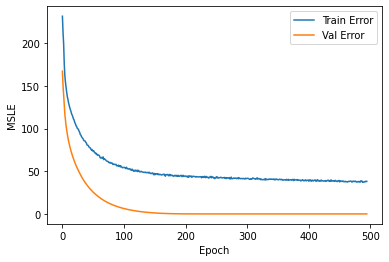

In [187]:
plot_history(hist2)

### Prediction

In [188]:
result2 = model2.predict(simple_test[['area_total','ceiling','rooms']])

In [213]:
submission_2 = pd.DataFrame()
submission_2['id'] = simple_test['apartment_id']
submission_2['price_prediction'] = result2
print("No. predictions:",len(submission_1['id']))

No. predictions: 9937


In [214]:
submission_2_sorted = submission_2.sort_values(['id', 'price_prediction'], ascending=True)
submission_2_sorted.to_csv('simple_test_2', index=False)

## Third test.
### Data preprocessing
Using more datapoint, and (maybe) dealing with nan-values more intelligently.

In [28]:
features = ["area_total", "rooms", "ceiling", "bathrooms_shared", "latitude", "longitude", "district", "constructed", "stories", "parking"] #Most useful features, from random forrest

no_outlayers = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]
labels3 = no_outlayers[features]
labels3 = labels3.fillna(labels3.mean())
targets3= no_outlayers['price']

test3 = test[features]
test3 = test3.fillna(test3.mean())

### Training

In [219]:
# Model 3
model3 = tf.keras.Sequential()
model3.add(Dense(8, activation=tf.nn.relu))
model3.add(Dropout(0.5))
model3.add(Dense(3, activation=tf.nn.relu))
model3.add(Dropout(0.5))
model3.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model3.compile(optimizer='adam', 
              loss='msle', 
              metrics=['msle']) #-msle


In [220]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=40)

history3 = model3.fit(x=labels3, y=targets3,
                    epochs=500, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


.......................................................................Epoch 00071: early stopping


In [221]:
# Results
hist3 = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch
hist3.tail()

,loss,msle,val_loss,val_msle,epoch
66,23.483461,23.483461,0.440707,0.440707,66
67,23.470810,23.470810,0.438360,0.438360,67
68,23.974895,23.974895,0.437580,0.437580,68
69,23.327051,23.327051,0.434328,0.434328,69
70,24.005039,24.005039,0.432989,0.432989,70


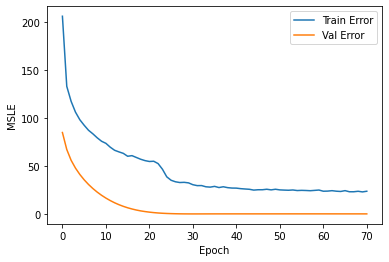

In [223]:
plot_history(hist3)

### Prediction

In [224]:
result3 = model3.predict(test3)

In [225]:
submission_3 = pd.DataFrame()
submission_3['id'] = test['apartment_id']
submission_3['price_prediction'] = result3
print("No. predictions:",len(submission_1['id']))

No. predictions: 9937


In [226]:
submission_3.to_csv('simple_test_3', index=False)

## Forth test. 
Change the model

In [47]:
# Model 4
model4 = tf.keras.Sequential()
model4.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
model4.add(Dropout(0.2))
model4.add(Dense(10, activation=tf.nn.relu))
model4.add(Dropout(0.2))
model4.add(Dense(5, activation=tf.nn.relu))
model4.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model4.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['mse', 'msle']) #-msle


In [48]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=50)

history4 = model4.fit(x=labels3, y=targets3,
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
...............................................................................................Epoch 00295: early stopping


In [49]:
# Results
hist4 = pd.DataFrame(history4.history)
hist4['epoch'] = history4.epoch
hist4.tail()

,loss,mse,msle,val_loss,val_mse,val_msle,epoch
290,0.230019,3.295058e+14,0.230019,0.101148,1.067132e+14,0.101148,290
291,0.221888,3.321349e+14,0.221888,0.105687,1.067430e+14,0.105687,291
292,0.218357,3.247943e+14,0.218357,0.107608,1.069866e+14,0.107608,292
293,0.214380,3.175532e+14,0.214380,0.107964,1.069738e+14,0.107964,293
294,0.210219,3.221096e+14,0.210219,0.113328,1.076653e+14,0.113328,294


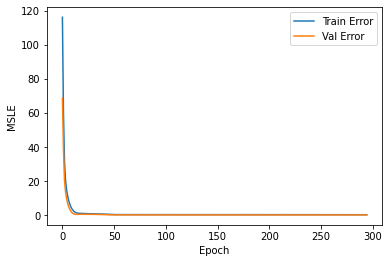

In [50]:
plot_history(hist4)

### Pred

In [254]:
result4 = model4.predict(test3)

In [255]:
submission_4 = pd.DataFrame()
submission_4['id'] = test['apartment_id']
submission_4['price_prediction'] = result4
print("No. predictions:",len(submission_1['id']))

No. predictions: 9937


In [256]:
submission_4.to_csv('simple_test_4_3', index=False)

In [263]:
import shap

In [264]:
# load JS visualization code to notebook
shap.initjs()

In [268]:
explainer = shap.KernelExplainer(model4.predict, shap.sample(labels3, 100))

In [269]:
shap_values = explainer.shap_values(test3, nsamples=100)


  0%|          | 0/9937 [00:00<?, ?it/s]

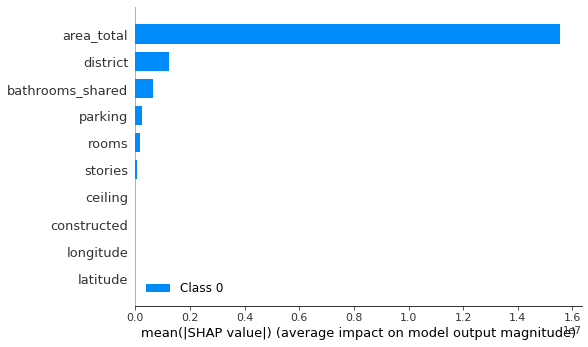

In [270]:
shap.summary_plot(shap_values, test3, feature_names=features)


## Fifth test
### Data processing
Same features as 3 and 4. Combine longitude and lattitude to distance.
Try to optimize for mse, monitor for msle.

In [19]:
features = ["area_total", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]

# Remove outlayers
outliers_value = 7 # 4 # MSLE 0.089582
no_outlayers = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]

# Train
labels5 = no_outlayers[features]
labels5 = labels5.fillna(labels5.mean())
targets5= no_outlayers['price'] # Non nan values here.

# Test
test5 = test[features]
test5 = test5.fillna(test5.mean())

In [20]:
normalized_labels5=(labels5-labels5.min())/(labels5.max()-labels5.min())

In [21]:
normalized_test5 = (test5-test5.min())/(test5.max()-test5.min())

### Train

In [22]:
# Model 5
model5 = tf.keras.Sequential()
model5.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
model5.add(Dropout(0.2))
model5.add(Dense(10, activation=tf.nn.relu))
model5.add(Dropout(0.2))
model5.add(Dense(5, activation=tf.nn.relu))
model5.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model5.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['msle']) #-msle


In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
 
history5 = model5.fit(x=normalized_labels5, y=targets5,
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....Epoch 00504: early stopping


In [24]:
# Results
hist5 = pd.DataFrame(history5.history)
hist5['epoch'] = history5.epoch
hist5.tail()


,loss,msle,val_loss,val_msle,epoch
499,0.178124,0.178124,0.094926,0.094926,499
500,0.179948,0.179948,0.095405,0.095405,500
501,0.180356,0.180356,0.095370,0.095370,501
502,0.179055,0.179055,0.094830,0.094830,502
503,0.179447,0.179447,0.095323,0.095323,503


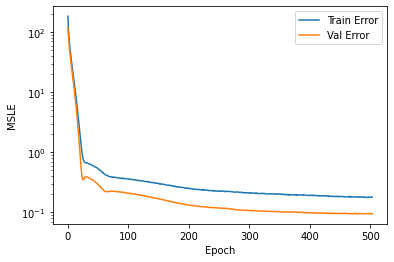

In [25]:
plot_history(hist5)

### Prediciton/ Submission

In [26]:
result5 = model5.predict(normalized_test5)

In [27]:
submission_5 = pd.DataFrame()
submission_5['id'] = test['apartment_id']      # Wait is this correct?
submission_5['price_prediction'] = result5 
print("No. predictions:", len(submission_5['id']))

No. predictions: 9937


------------Result------------
area_total           0.961913
area_living          0.768434
floor                0.109841
rooms                0.594669
ceiling              0.017165
bathrooms_shared     0.348166
bathrooms_private    0.135905
balconies            0.078489
latitude             0.012811
longitude            0.015363
constructed         -0.019212
price_prediction     1.000000
Name: price_prediction, dtype: float64


<AxesSubplot:>

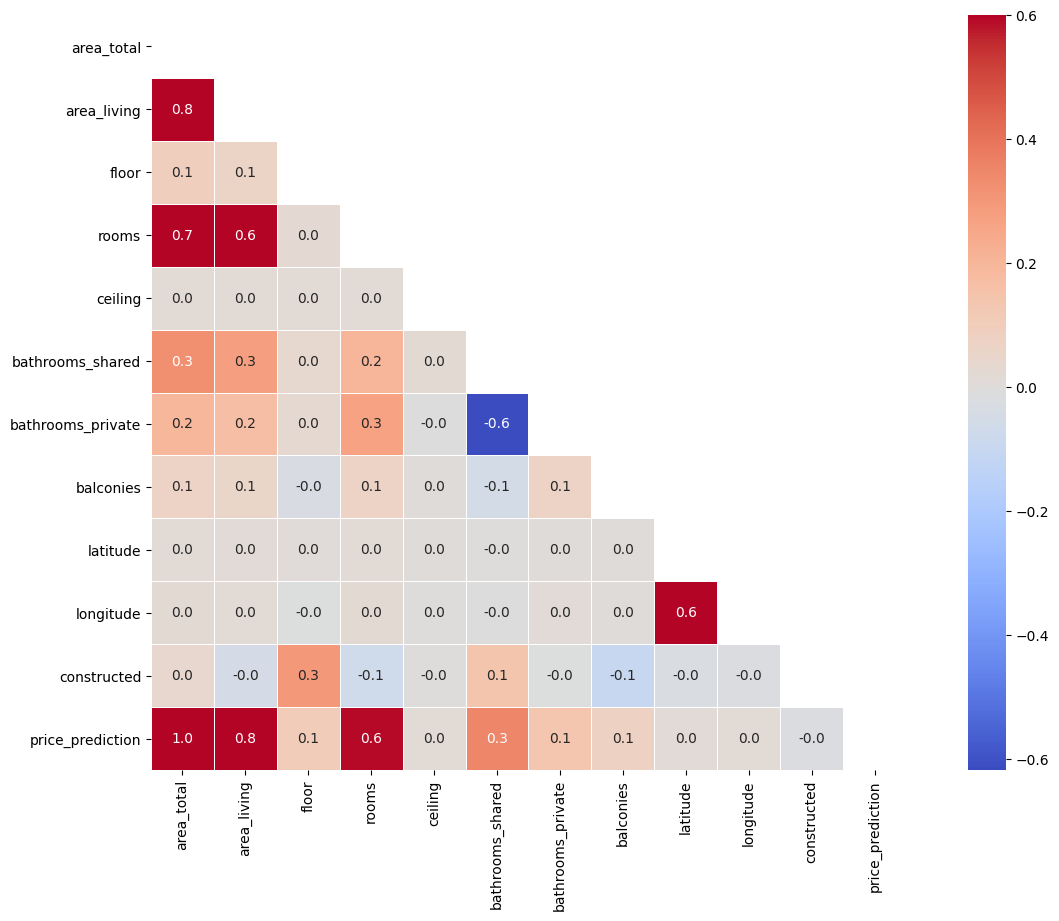

In [28]:
df_result = pd.merge(normalized_test5, submission_5['price_prediction'], left_index=True, right_index=True)
# Compute the correlation matrix
result_corr = df_result.corr()
print("------------Result------------")
print(result_corr["price_prediction"])

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(result_corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
sns.heatmap(result_corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

In [29]:
submission_5.to_csv('simple_test_5_3', index=False)

## LOOK INTO. 
- K-fold validation.
- different activations.
- Optimize for mse was better?
- longiture/lattitude combined to distance from centre?
- one hot encoding for categorical data.
- alternative for filling in nan: mean doesnt work if 90% is nan, and the rest is 1 (balcony)


## Sixth test
Adding new knowledge from EDA
1. Adding polar coordinates - not good?
2. Random validation dataset
3. Add more useful features

In [30]:
features = ["area_total", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]

# Remove outlayers
outliers_value = 7 # 4 # MSLE 0.089582
no_outlayers = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]

# Train
labels5 = no_outlayers[features]
labels5 = labels5.fillna(labels5.mean())
targets5= no_outlayers['price'] # Non nan values here.

# Test
test5 = test[features]
test5 = test5.fillna(test5.mean())

In [31]:
normalized_labels5=(labels5-labels5.min())/(labels5.max()-labels5.min())

In [32]:
normalized_test5 = (test5-test5.min())/(test5.max()-test5.min())

In [34]:
# 1 first change from 5
normalized_labels5, normalized_test5 = polar_coordinates(normalized_labels5, normalized_test5)

### Train

In [36]:
# Model 5
model5 = tf.keras.Sequential()
model5.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
model5.add(Dropout(0.2))
model5.add(Dense(10, activation=tf.nn.relu))
model5.add(Dropout(0.2))
model5.add(Dense(5, activation=tf.nn.relu))
model5.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model5.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['msle']) #-msle


In [37]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
 
history5 = model5.fit(x=normalized_labels5, y=targets5,
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...Epoch 00503: early stopping


In [38]:
# Results
hist5 = pd.DataFrame(history5.history)
hist5['epoch'] = history5.epoch
hist5.tail()


,loss,msle,val_loss,val_msle,epoch
498,0.119922,0.119922,0.053351,0.053351,498
499,0.119487,0.119487,0.053774,0.053774,499
500,0.118610,0.118610,0.053732,0.053732,500
501,0.120640,0.120640,0.053730,0.053730,501
502,0.120633,0.120633,0.053278,0.053278,502


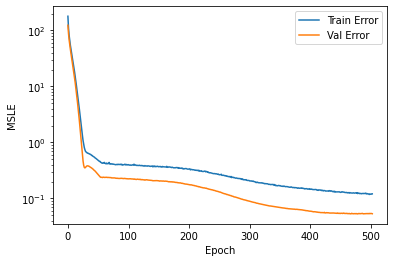

In [39]:
plot_history(hist5)

### Predict

In [40]:
result5 = model5.predict(normalized_test5)

In [41]:
submission_5 = pd.DataFrame()
submission_5['id'] = test['apartment_id']      # Wait is this correct?
submission_5['price_prediction'] = result5 
print("No. predictions:", len(submission_5['id']))

No. predictions: 9937


------------Result------------
area_total           0.975220
area_living          0.817739
floor                0.150537
rooms                0.658111
ceiling              0.026818
bathrooms_shared     0.332993
bathrooms_private    0.181756
balconies            0.111203
latitude             0.031581
longitude            0.005677
constructed          0.034214
r                   -0.040104
theta                0.027414
price_prediction     1.000000
Name: price_prediction, dtype: float64


<AxesSubplot:>

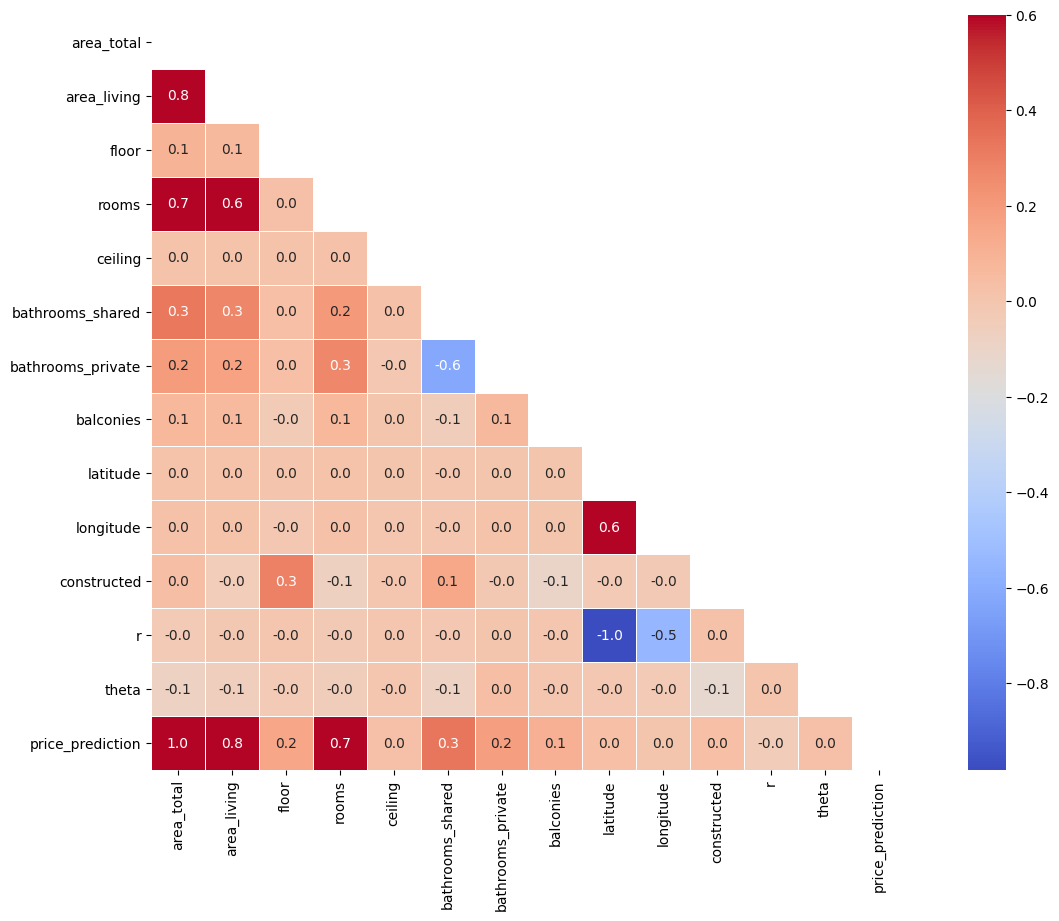

In [42]:
df_result = pd.merge(normalized_test5, submission_5['price_prediction'], left_index=True, right_index=True)
# Compute the correlation matrix
result_corr = df_result.corr()
print("------------Result------------")
print(result_corr["price_prediction"])

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(result_corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
sns.heatmap(result_corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

In [43]:
submission_5.to_csv('simple_tests/simple_test_6_1', index=False)